In [1]:
'''Author: Olivia McAuley'''

import numpy as np

import scipy as sc

import astropy
from astropy import units
from astropy import units as u

import galpy
import galpy.df
from galpy.df import isotropicPlummerdf 
from galpy.orbit import Orbit
from galpy import potential
from galpy.potential import flatten, MWPotential2014, vcirc, DehnenBarPotential, SolidBodyRotationWrapperPotential, plotDensities
from galpy.potential import SoftenedNeedleBarPotential, DehnenSmoothWrapperPotential, evaluatePotentials, plotPotentials, PlummerPotential
from galpy.potential import RotateAndTiltWrapperPotential
from galpy.actionAngle import actionAngleAdiabatic, actionAngleStaeckel
from galpy.util import conversion, coords
from galpy.util.plot import dens2d

from matplotlib.pyplot import *
from matplotlib import pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', **{'family':'Computer Modern','size':20})
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
from matplotlib import colors as mc
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
##### Important scale factors #####

# Scales to be use for conversion from natural coordinates
ro = 8. # (kpc) scale radii
vo = 220. # (km/s) scale velocity at ro

# Set model parameters for potentials and DF:
hro  = 1./3.   # Scale length for surface density
sro  = 0.16    # Radial velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
szo  = sro/2   # Vertical velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
hsro = 3.*hro #3./4.    # Radial scale length for radial velocity dispersion profile
hszo = hsro    # Radial scale length for vertical velocity dispersion profile

# Set parameters for initial conditions
nsample=1000 #1000     # number of samples
nbatch=10 #200       # number of batches of nsample orbits
rmin = 0.375 # sets scaled rmin = 3kpc
rmax = 1.125 # sets scaled rmax = 9kpc
zmax=0.3    # sets scales zmax = 2.4 kpc
AAType = 'stklAA' # Action Angle approx for ICs

In [3]:
### Set up underlying initial axi-symmetric potential for the disk

dpType = 'MW14'
mwp = MWPotential2014

In [4]:
### Set up the growing bar potential
# The Dehnen bar potential is initialized to start bar formation four bar periods before the 
# present day and to have completely formed the bar two bar periods ago. 
# We can integrate back to the time before bar-formation:

##### Set up the bar potential parameters #####
rbo = 0.5 # rbo = 4 kpc # 0.625 # Bar length is in natural units (set to 5 kpc - Li+2016 at 6.7 kpc for same vo)
ao = rbo # Bar half length
bo = rbo/4 # Tri-axial softening length
co = rbo/4 # Prolate softening length
simname = 'GrowBar_CR4'
# CRo = 5./6 # 220 km s^-1 / 33km s^-1 kpc^-1 = 20/3 kpc #(20/3 kpc) / 8 kpc = 5/6 This is in natural units # 0.8*rbo  # Corotation radius  [0.8*rbo=4kpc, 1.2*rbo=6kpc, 1.6*rbo=8kpc][Li+2016 bar pattern speed=33km/s/kpc: https://iopscience.iop.org/article/10.3847/0004-637X/824/1/13/pdf]
CRo = .5 # CRo = 4 kpc
v_c = vcirc(mwp, R = CRo)# v_c in natural units and it's the v_c at corotation radius
omegabo = v_c/CRo# Pattern speed based on CR #orbital freq = v_c/R : we need to figure out v_c at CR
print ('This is omegabo in physical units', omegabo*(vo/ro),'kpc')
print ('This is omegabo in natural units', omegabo)

Ab = 1 # Bar strength (defaults to Ab=1)
pa = 0. # The position angle of the x axis (radians)

##### Softened Needle Bar Potential #####

# Ab2=5
# bp2=SoftenedNeedleBarPotential(amp=Ab2,a=ao,b=bo,c=co,pa=pa,omegab=omegabo)
# bp = SoftenedNeedleBarPotential(amp=Ab,a=ao,b=bo,c=co,pa=pa,omegab=omegabo,ro=ro,vo=vo,normalize=True)

##############################################

# Initialize to start bar formation at t=0 (tform) 
# Completely formed after two bar periods (tsteady)
# Let bar evolve for 30 rotations after growth stops
Nrot = 4 #30 # Tbar to evolve # Nrot=3 evolves bar for 3 rotations after growth stops
Ngrow = 1 #2 # Tbar to grow bar # Ngrow=1 bar completely formed after one bar periods
Nequel = 0 # Tbar to equelibrate

tform = 0 #-(Nequel+Ngrow)*2.*np.pi/omegabo # Start time (four bar periods ago) 

tsteady = Ngrow*2*np.pi/omegabo # time from tform where bar is fully grown

print ('This is tsteady from bar potential:',tsteady)

##### Grow the bar #####

# btp = DehnenSmoothWrapperPotential(pot=bp,
#                                    tform=0,#-4.*2.*np.pi/bp.OmegaP(),
#                                    tsteady=Ngrow*2.*np.pi/bp.OmegaP())

###############################################

# print ('This is omegap:',2*np.pi/bp.OmegaP())

##### Dehnen Bar Potential #####

bp = DehnenBarPotential(amp=Ab, omegab=omegabo, rb=rbo/2, barphi=0, tform=tform, tsteady=tsteady, Af=Ab)

###############################################

##### Testing to get contour plot of the bar to show up #####
# bpL5 = DehnenBarPotential(amp=Ab, omegab=omegabo, rb=rbo/2, barphi=0, tform=-Ngrow*2*np.pi/omegabo, tsteady=0, Af=Ab)

###############################################

##### Testing for half amplitude to see if the maximum position in the rotating frame moves compared to full amplitude #####
# bphalf = DehnenBarPotential(amp=Ab/2, omegab=omegabo, rb=rbo/2, barphi=0, tform=0, tsteady=tsteady, Af=Ab/2)

# bpL5half = DehnenBarPotential(amp=Ab/2, omegab=omegabo, rb=rbo/2, barphi=0, tform=-Ngrow*2*np.pi/omegabo, tsteady=0, Af=Ab)

###############################################

# pot=[mwp,btp]
# mwp.plot(t=0,rmin=-1.5,rmax=1.5,zmin=-1.5,zmax=1.5,xy=True,justcontours=True,ncontours=3)
# mwp.plot()
# plt.show()

#tested that bp.OmegaP() and omegabo are the same and they are
barT = 2.*np.pi/omegabo # Period of rotation for the bar #orbital period

# print('This is barT',barT)

print(simname,' has CR = ',str(CRo*ro))


This is omegabo in physical units 55.6739990293091 kpc
This is omegabo in natural units 2.02450905561124
This is tsteady from bar potential: 3.103559991379029
GrowBar_CR4  has CR =  4.0


In [5]:
### This little calculator helps define appropriate length and spacing for integration

#barT =2.*np.pi/omegabo; omegabo = 1./CRo
TbarPhys = (barT*ro*units.kpc/(vo*units.km/units.s)).to(units.Gyr) # barT*ro/vo
tfgoal = 5*units.Gyr
print('A single bar rotation: ',TbarPhys.to(units.Myr))
print('It will rotate ',tfgoal/TbarPhys,' in ',tfgoal)
print('     That is' ,1*units.Gyr/TbarPhys, 'rotations per Gyr')
print('\n')

Ntot = Nequel+Ngrow+Nrot 
tfnat = (Ngrow+Nrot)*barT
tfPhys = (Ngrow+Nrot)*TbarPhys
print('After exactly ',Nrot+Ngrow,' rotations the final time will be:')
print('     ',tfnat, 'natural units')
print('     ',tfPhys)
print('\n')

def timescale(R,vc):
    R = R *u.kpc
    vc = vc *u.km/u.s
    T = R/vc *2 *np.pi
    return T.to(u.Myr)
dtmax = timescale(rmin*ro,vcirc(mwp,rmin,vo=vo,ro=ro))
# print ('This is dtmax:',dtmax)
print('Want max timestep to be '+str(np.round(dtmax/10,2)))

dtgoal = 5*units.Myr #0.5*units.Myr
Tperitr = 2 # bar orbit period per iterations
nitr = int(Ntot/Tperitr) # NUMBER OF ITERATIONS
ttotGyr = Ntot*TbarPhys.to(units.Myr)
x = np.round((ttotGyr)/dtgoal,2)
TNrough = TbarPhys/(dtgoal.to(units.Gyr))
TNround = 20 #225 #np.ceil(TNrough) #time step
ntitr = TNround*Tperitr
nttot = ntitr*nitr
print('For dt='+str(dtgoal)+' there are approximately '+str(x)+' steps over full simulation,')
print('   where one bar orbit every '+str(TNrough)+' time-steps.')
print('Setting to '+str(TNround)+' steps per one bar orbit, every step is '+str((TbarPhys/TNround).to(units.Myr)))
print('   and '+str(Ntot)+' rotations ('+str(Nequel)+' to equelibrate, '+str(Ngrow)+' to grow bar, '+str(Nrot)+' Tbar to evolve) takes '+str(Ntot*TNround)+' time-steps')
print('   For '+str(nitr)+' iterations with '+str(Tperitr)+'Tbar each, there are '+str(ntitr)+' steps per iteration.')
print('\n')

tfnatitr = barT*Tperitr
tfPhysitr = TbarPhys*Tperitr
dtMyr = ((tfPhysitr)/ntitr).to(units.Myr)

# print ('\n This is TNrough:',TNrough)
# print ('This is dtMyr:',TbarPhys/dtMyr,'\n')

print('tfnat = '+str(tfnat)+' # Final integration time after '+str(Ntot)+' rotations in natural units')
print('tfGyr = '+str(tfPhys)+' # Final integration time after '+str(Ntot)+' rotations in Gyr')
print('nttot = '+str(nttot)+'         # Number of integration steps by final iteration')
print('tfnatitr = '+str(tfnatitr)+' # Integration time in natural units for this iteration')
print('tfPhysitr = '+str(tfPhysitr)+' # Integration time in Gyr for this iteration')
print('ntitr    = '+str(ntitr)+'    # Number of integration steps this iteration(2Tbar long)')
print('dtMyr = '+str(np.round(dtMyr,3))+' # Length of each step in Myr')
print('One bar orbit every '+str(TbarPhys/dtMyr.to(units.Gyr))+' time-steps')

A single bar rotation:  110.3504297842304 Myr
It will rotate  45.31019960480955  in  5.0 Gyr
     That is 9.06203992096191 rotations per Gyr


After exactly  5  rotations the final time will be:
      15.517799956895145 natural units
      0.551752148921152 Gyr


Want max timestep to be 8.69 Myr
For dt=5.0 Myr there are approximately 110.35 steps over full simulation,
   where one bar orbit every 22.07008595684608 time-steps.
Setting to 20 steps per one bar orbit, every step is 5.5175214892115205 Myr
   and 5 rotations (0 to equelibrate, 1 to grow bar, 4 Tbar to evolve) takes 100 time-steps
   For 2 iterations with 2Tbar each, there are 40 steps per iteration.


tfnat = 15.517799956895145 # Final integration time after 5 rotations in natural units
tfGyr = 0.551752148921152 Gyr # Final integration time after 5 rotations in Gyr
nttot = 80         # Number of integration steps by final iteration
tfnatitr = 6.207119982758058 # Integration time in natural units for this iteration
tfPhysitr 

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/galpy/potential/PowerSphericalPotentialwCutoff.py:89: RuntimeWarning: invalid value encountered in true_divide
  out= 2.*numpy.pi*self.rc**(3.-self.alpha)*(1/self.rc*special.gamma(1.-self.alpha/2.)*special.gammainc(1.-self.alpha/2.,(r/self.rc)**2.)-special.gamma(1.5-self.alpha/2.)*special.gammainc(1.5-self.alpha/2.,(r/self.rc)**2.)/r)

/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1369: RuntimeWarning: divide by zero encountered in true_divide
  out= -special.xlogy(1./r,1.+r/self.a) # stable as r -> infty

This is evalPot(mwp+bp): [-4.66098373 -3.92536906 -3.79911929 -3.70518758 -3.6227179  -3.5444016
 -3.46667171 -3.38745091 -3.30537559 -3.21946068 -3.12893163 -3.03313145
 -2.93146587 -2.82954134 -2.73978582 -2.65938054 -2.5860311  -2.51821178
 -2.45487764 -2.39529215 -2.33892112 -2.28536598 -2.2343208  -2.18554418
 -2.13884055 -2.09404755 -

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


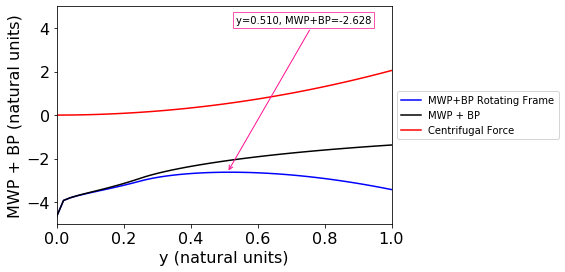

This is xmax at t=tsteady: 0.5102040816326531
This is L4/5 in natural units: 0.5102040816326531
This is L4/5 in physical units: 4.081632653061225 kpc


In [6]:
##### Plot the potential in rotating frame #####

Lz = CRo*v_c # angular momentum

radius = np.linspace(0,1) # this is the radius to be given in the centrifugal term

# centrifugal_term_Lz = 0.5*Lz**2/(radius**2)
centrifugal_term = 0.5*omegabo**2 * radius**2

y = np.linspace(0,1) # will give the y axis coordinate

potential_term = evaluatePotentials(mwp+bp, y, z=0, phi=0, t=tsteady)
# potential_termhalf = evaluatePotentials(mwp+bphalf, y, z=0, phi=0, t=tsteady)

print ('This is evalPot(mwp+bp):',potential_term,'\n')
# print ('This is evalPot(mwp+bphalf):',potential_termhalf)


# print('This is the shape of MWP + BP:',np.shape(potential_term))

rot_frame = potential_term - centrifugal_term # put the potential in rotating frame
# rot_framehalf = potential_termhalf - centrifugal_term # put the potential in rotating frame


##### Annotate maximum value in graph #####

fig, ax = plt.subplots()
ax.plot(y,rot_frame,color='b',label='MWP+BP Rotating Frame')
# ax.plot(y,rot_framehalf,color='g',label='MWP+BPhalf Rotating Frame')

# ax.plot(y,rot_frameL5,color='g',label='MWP+BPL5 Rotating Frame ')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "y={:.3f}, MWP+BP={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="deeppink", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60", ec='deeppink')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(y,rot_frame)

plot(y, potential_term,color='k',label='MWP + BP')
plot(y, centrifugal_term,color='r',label='Centrifugal Force')
plt.xlabel('y (natural units)')
plt.ylabel('MWP + BP (natural units)')
plt.ylim(-5,5)
plt.xlim(0,1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
##########################################

xmax = y[np.argmax(rot_frame)]
ymax = rot_frame.max()
print ('This is xmax at t=tsteady:', xmax)
# xmaxhalf = y[np.argmax(rot_framehalf)]
# print ('This is xmaxhalf in natural units:', xmaxhalf)
# print ('This is xmaxhalf in physical units:', xmaxhalf*ro)

L5 = xmax

print ('This is L4/5 in natural units:',L5)
print ('This is L4/5 in physical units:',L5*ro,'kpc')

# print ('this is 2$\pi$\$\Omega_{b}$:',2*np.pi/omegabo)

In [ ]:
# ##### Find the second smallest minimum value in a given function: #####
# ##### https://theprogrammingexpert.com/python-find-second-smallest-value-in-list/ #####
# # def findSecondSmallest(lst):
# #     firstSmallest = min(lst[0],lst[1])
# #     secondSmallest = max(lst[0],lst[1])
# #     for i in range(2,len(lst)):
# #         if lst[i] < firstSmallest:
# #             secondSmallest = firstSmallest 
# #             firstSmallest = lst[i]
# #         elif lst[i] < secondSmallest and firstSmallest < lst[i]:
# #             secondSmallest = lst[i]
# #     return secondSmallest 
# ######################################################################

# # x = np.linspace(0,1)

# # potential = evaluatePotentials(mwp+bpL5, x, z=0, phi=0)

# # print(y)

# # print('This is the potential value in natural units where L5 is located',findSecondSmallest(y))

# ##### https://stackoverflow.com/questions/46909373/how-to-find-the-exact-intersection-of-a-curve-as-np-array-with-y-0/46911822#46911822 #####
# # def find_roots(x,y):
# #     s = np.abs(np.diff(np.sign(y))).astype(bool)
# #     return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

# # z = find_roots(radius,y-findSecondSmallest(y))
# # print(z)
# ######################################################################

# ##### https://stackoverflow.com/questions/11467649/how-do-i-find-x-given-y-or-vice-versa-in-numpy #####
# # order = np.argsort(potential)
# # potential = potential[order]
# # x = x[order]
# # def what_is_x_when_y_is(input, x, y):
# #     return x[y.searchsorted(input, 'left')]
# # print ('This is L5 in natural units',what_is_x_when_y_is(findSecondSmallest(potential), x, potential))

# # L5 = what_is_x_when_y_is(findSecondSmallest(potential), x, potential)
# # print('L5 is located at',L5*ro,'kpc')
# ###################################################################################

# # fig = plt.figure()
# # # ax = fig.add_subplot(aspect='equal')
# # # ax.set_aspect('equal')
# # # plt.axes().set_aspect('equal')
# # radius=np.linspace(0,1)
# # plot(radius, evaluatePotentials(mwp+bp, radius, z=0, phi=0),color='k')
# # # plt.plot(z, np.zeros(len(z))+findSecondSmallest(y))
# # # plt.hlines(findSecondSmallest(y),0,1)
# # plt.vlines(L5,-1,-7,label='L5',color='deeppink')
# # plt.xlabel('R (natural units)')
# # plt.ylabel('MWP + BP (natural units)')
# # # plt.xlim(0,1)
# # # plt,ylim(-2.2,-1.1)
# # plt.legend()
# # plt.show()


# ##### Plot the potential in rotating frame #####

# Lz = CRo*v_c # angular momentum

# radius = np.linspace(0,1) # this is the radius to be given in the centrifugal term

# centrifugal_term_Lz = 0.5*Lz**2/(radius**2)
# centrifugal_term = 0.5*omegabo**2 * radius**2

# y = np.linspace(0,1) # will give the y axis coordinate

# potential_term = evaluatePotentials(mwp+bp, y, z=0, phi=0, t=np.pi)
# potential_termL5 = evaluatePotentials(mwp+bpL5, y, z=0, phi=0, t=np.pi)

# # print('This is the shape of MWP + BP:',np.shape(potential_term))

# rot_frame = potential_term - centrifugal_term # put the potential in rotating frame
# rot_frameL5 = potential_termL5 - centrifugal_term # put the potential in rotating frame

# # rot_frame_Lz = potential_term - centrifugal_term_Lz # put the potential in rotating frame

# # print ('This is the centrifugal term:',centrifugal_term, '\n')
# # print ('Evaluate mwp+bp from 0 to 1 and phi=0:', potential_term,'\n')
# # print ('This is rotating frame using $\Omega_{b}$', rot_frame)


# ##### Show plot using $\Omega_{b}$ and L_{z} to compare and contrast the two plots #####

# # plt.figure()
# # plot(y, rot_frame,color='b',label='rotating frame using $\Omega_{b}$')
# # plot(y, rot_frame_Lz,color='deeppink',label='rotating frame using Lz')
# # plot(y, potential_term,color='k',label='MWP + BP')
# # plot(y, centrifugal_term,color='r',label='centrifugal using $\Omega_{b}$')
# # plot(y, centrifugal_term_Lz,color='g',label='centrifugal using Lz')
# # plt.xlabel('y (natural units)')
# # plt.ylabel('MWP + BP (natural units)')
# # plt.ylim(-5,5)
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.show()
# ##########################################

# ##### Annotate maximum value in graph #####

# fig, ax = plt.subplots()
# ax.plot(y,rot_frame,color='b',label='MWP+BP Rotating Frame')
# # ax.plot(y,rot_frameL5,color='g',label='MWP+BPL5 Rotating Frame ')

# def annot_max(x,y, ax=None):
#     xmax = x[np.argmax(y)]
#     ymax = y.max()
#     text= "y={:.3f}, MWP+BP={:.3f}".format(xmax, ymax)
#     if not ax:
#         ax=plt.gca()
#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="deeppink", lw=0.72)
#     arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60", ec='deeppink')
#     kw = dict(xycoords='data',textcoords="axes fraction",
#               arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
#     ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

# annot_max(y,rot_frame)
# # annot_max(y,rot_frameL5)

# plot(y, potential_term,color='k',label='MWP + BP')
# plot(y, centrifugal_term,color='r',label='Centrifugal Force')
# plt.xlabel('y (natural units)')
# plt.ylabel('MWP + BP (natural units)')
# plt.ylim(-5,5)
# plt.xlim(0,1)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()
# ##########################################

# xmax = y[np.argmax(rot_frame)]
# ymax = rot_frame.max()
# xmaxL5 = y[np.argmax(rot_frameL5)]
# ymaxL5 = rot_frameL5.max()
# print ('This is xmax:', xmax)
# print ('This is ymax:', ymax)
# # print ('This is ymax with bpL5', ymaxL5)
# # print ('This is L4/5 with bpL5 in natural units', xmaxL5)
# # print ('This is L4/5 with bpL5 in physical units', xmaxL5*ro)

# L5 = xmax
# print ('This is L4/5 in natural units:',L5)
# print ('This is L4/5 in physical units:',L5*ro)

# print ('this is 2$\pi$\$\Omega_{b}$',2*np.pi/omegabo)

# ##### Show plot of centrifugal term using $\Omega_{b}$ #####

# # plt.figure()
# # plot(y, rot_frame,color='b',label='Rotating Frame')
# # plot(y, potential_term,color='k',label='MWP + BP')
# # plot(y, centrifugal_term,color='r',label='Centrifugal')
# # plt.xlabel('y (natural units)')
# # plt.ylabel('MWP + BP (natural units)')
# # plt.xlim(0,1)
# # plt.ylim(-5,5)
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.show()
# ##########################################

# # potential_term = evaluatePotentials(bp, x, z=0, phi=0)


# # rot_frame = potential_term - centrifugal_term # put the potential in rotating frame

# # # print ('This is the centrifugal term',centrifugal_term)
# # print ('Evaluate bp from 0 to 1 and phi=0', evaluatePotentials(bp, x, z=0, phi=0))

# # ##### Show plot #####

# # plt.figure()
# # plot(y, rot_frame,color='k')
# # # plot(y, potential_term,color='k')
# # plt.xlabel('y (natural units)')
# # plt.ylabel('BP (natural units)')
# # plt.show()
# # ##########################################

# # potential_term = evaluatePotentials(mwp, x, z=0, phi=0)


# # rot_frame = potential_term - centrifugal_term # put the potential in rotating frame

# # # print ('This is the centrifugal term',centrifugal_term)
# # print ('Evaluate mwp from 0 to 1 and phi=0', evaluatePotentials(mwp, x, z=0, phi=0))

# # ##### Show plot #####

# # plt.figure()
# # plot(y, rot_frame,color='k')
# # # plot(y, potential_term,color='k')
# # plt.xlabel('y (natural units)')
# # plt.ylabel('MWP (natural units)')
# # plt.show()
# # ##########################################


In [ ]:
#### radius = np.linspace(0.01,1) # this is the radius to be given in the centrifugal term
# # bar_pot = .5 * v_c**2 * np.log(radius**2)
# bar_pot = .5 * v_c**2 * np.cos(radius**2) +(1/(r*(1+radius**2)))+1/np.sqrt(radius**2) + (1/radius**1.8)*np.exp(-radius**2)

# Lz = CRo*v_c # angular momentum
# # radius = np.linspace(0,1) # this is the radius to be given in the centrifugal term
# centrifugal_term = 0.5*Lz**2/radius**2

# rot_frame = bar_pot #+ centrifugal_term

# plt.figure()
# plot(radius, rot_frame,color='k')
# plt.xlabel('x (natural units)')
# plt.ylabel('MWP + BP (natural units)')
# plt.show()

In [ ]:
# from scipy import integrate
# from scipy.special import gamma, gammainc
# R=np.linspace(0,1)
# z=0
# alpha=1.8
# rc=1.9/8.
# # normalize=0.05
# r= np.sqrt(R**2.+z**2.)
# out= 2.*np.pi*rc**(3.-alpha)*(1/rc*gamma(1.-alpha/2.)*gammainc(1.-alpha/2.,(r/rc)**2.)-gamma(1.5-alpha/2.)*gammainc(1.5-alpha/2.,(r/rc)**2.)/r)
# print(out)



In [7]:
##### Set up Plummer DF to place the center of the DF at some radius #####

# mwp = MWPotential2014

b_param = 1.07*((10**-3)/ro) # 1.07 is in pc and we have to get it in natural units so convert pc to kpc, then divide by ro to get b in natural units

print ('This is b_param in natural units:',b_param)
# b_param = 1.

##### Set the amplitude of the cluster potential #####

amp = 10**-6 # = GM/ro*vo = G*(5000M_{solar})/(8kpc*220km/s)
########################################################

##### Set up the cluster potential which is made from the Plummer Potential and the Plummer DF #####

# pp = potential.PlummerPotential(amp = 1, b = b_param, ro=None, vo=None) # need to change amp and b param. b*ro so need to check out 6791 and see how big it is for scale parameter (1 kpc or 100 kpc)
pp = PlummerPotential(amp = amp, b = b_param, ro=None, vo=None) # need to change amp and b param. b*ro so need to check out 6791 and see how big it is for scale parameter (1 kpc or 100 kpc)
# b was found doing a volumn integration with the Plummer density and using r=r_{h}=2.3kpc from Martinez-Medina+18
# look at onenote notes from September 29, 2021

pdf = isotropicPlummerdf(pot=pp, ro=None, vo=None)
###########################################################

##### Set up the particles in the sample #####

sam = pdf.sample(n=nbatch*nsample, return_orbit=True)
#output of sample is of the form: (R, vR, Vt, z, vz, phi)
############################################################

# print('This is the shape of the sample',np.shape(sam))

##### Return the maximum of an array or maximum along an axis #####

# print('This is the amax of the radial velocity of the sample:',np.amax(sam.vr()))
###################################################################

##### Place cluster at bar's corotation #####

x0,v0= [0.,L5,0.], [-vcirc(mwp,R = L5),0.,0.] #Put cluster at L5
###################################################################

##### Testing of where to place cluster initially #####

# x0,v0= [0.,0.5,0.], [-vcirc(mwp, R=0.5),0.,0.] #move Plummer df to 4kpc with circular velocity at 4kpc

# x0,v0= [0.5,0.5,0.], [-vcirc(mwp, R=0.5),0.,0.] #move Plummer df to 4kpc with circular velocity at 4kpc

# x0,v0 = [0.,0.,0.], [0.,0.,0.] #Set clutster at the center of the galaxy

# x0,v0 = [0.,CRo,0.], [-vcirc(mwp,R = CRo),0.,0.] #Set cluster at CR where we know it's in a stable orbit
####################################################################

##### Test to see what units circular velocity and coroation are in #####

# print('This is vcirc(mwp,R = CRo):',vcirc(mwp,R = CRo))
# print('This is CRo:',CRo)

# print ('corotation in kpc:',CRo*ro)
# print ('circular velocity at corotation in km/s:',vcirc(mwp,R = CRo)*vo)
######################################################################

##### Shift position of the cluster and convert to cylindrical coordinates #####
shifted_pos = coords.rect_to_cyl(sam.x()+x0[0],sam.y()+x0[1],sam.z()+x0[2])

# shifted_pos1 = coords.rect_to_cyl(sam.x()+x1[0],sam.y()+x1[1],sam.z()+x1[2]) 

# shifted_pos output: gives (R, phi, z) shifted by position we set
######################################################################

##### Shift velocity of the cluster and convert to cylindrical coordinates #####

# shifted_vel = coords.rect_to_cyl_vec(sam.vx()+v0[0],sam.vy()+v0[1],sam.vz()+v0[2],*shifted_pos,cyl=True) #True: position is already in cyl coord

shifted_vel= coords.rect_to_cyl_vec(sam.vx()+v0[0],sam.vy()+v0[1],sam.vz()+v0[2],shifted_pos[0],shifted_pos[1],shifted_pos[2],cyl=True) #True: position is already in cyl coord

# shifted_vel1= coords.rect_to_cyl_vec(sam.vx()+v1[0],sam.vy()+v1[1],sam.vz()+v1[2],shifted_pos1[0],shifted_pos1[1],shifted_pos1[2],cyl=True) #True: position is already in cyl coord

# print('This is shifted_vel[1] in cyclindrical coords [vR, v_phi, vz]:',shifted_vel[1])
########################################################################

##### Set up cluster's orbits #####

shifted_cluster = Orbit(np.array([shifted_pos[0],shifted_vel[0],shifted_vel[1],shifted_pos[2],shifted_vel[2],shifted_pos[1]]).T)

# shifted_cluster1 = Orbit(np.array([shifted_pos1[0],shifted_vel1[0],shifted_vel1[1],shifted_pos1[2],shifted_vel1[2],shifted_pos1[1]]).T)

# The shifted_cluster output is in the form: (R, vr, phi,, vphi, z, vz)
##########################################################################

# print('This is vx:',sam.vx)

# print ('shape of the shifted sample',shifted_cluster.shape)
# print ('this is shifted sample',shifted_cluster[0])

# need to essentially shift potential. This is shifting the particles themselves. But start with not shifting pot to se what hPPENS

# time scale at cro: vc= 2pi*cro/time and then do an orbit then increast orbits
# time = 2*np.pi*CRo/vcirc(mwp, R = CRo)
# print ('time in Megayear',time*(ro*(3.086*10**16)/vo)*(1/(60*60*24*360*10**6))) #units of Megayear

# timescale: take vel dispersion scale param...divide them to get timescale param

##### Wrap the cluster so that the Plummer Potential itself is shifted to the L4/5 using RotateAndTiltWrapper #####
##### and make sure it's rotating with the bar using SolidBodyRotationWrapper #####
'''https://docs.galpy.org/en/latest/reference/potentialrotateandtiltwrapper.html#galpy.potential.RotateAndTiltWrapperPotential'''

rtwp = RotateAndTiltWrapperPotential(amp=1.0, galaxy_pa=None, zvec=None, offset=[0,L5,0], pot=pp)

'''
https://docs.galpy.org/en/latest/reference/potentialsolidbodyrotationwrapper.html?highlight=wrapper

amp - amplitude to be applied to the potential (default: 1.)

pot - Potential instance or list thereof; this potential is made to rotate around the z axis by the wrapper
omega= (1.) the pattern speed (can be a Quantity)

pa= (0.) the position angle (can be a Quantity)
'''
sbwp = SolidBodyRotationWrapperPotential(amp=1.0, pot=rtwp, omega=omegabo, pa=np.pi/2)
##################################################################



This is b_param in natural units: 0.00013375


In [ ]:
##### Rotation Curve for Plummer Potential #####

from galpy.potential import plotRotcurve
plotRotcurve(pp) #isn't R_o = 8kpc here? Is this plot misleading? Do we want R_o to be scaled to the cluster instead of the MW galaxy?
plt.xlim(0,1)

In [ ]:
# print ('this is CRo in natural units',CRo)
# xs = [e.x() for e in shifted_cluster]
# ys = [e.y() for e in shifted_cluster]
# figure()
# plt.ylabel('y')
# plt.xlabel('x')
# # plt.ylim(.35,.38)
# # plt.xlim(-.01,.01)
# plot(xs,ys,',')

In [ ]:
# phis = [e.phi() for e in shifted_cluster]
phi = np.linspace(0,2*np.pi)
# print (np.shape(phi))
r = L5

potential_term = evaluatePotentials(mwp+bp, R=L5 , z=0, phi=phi, t=tsteady)
plt.vlines(np.pi/2,-2.2,-2)
plt.ylabel('MWP+BP')
plt.xlabel('$\phi$')


plot(phi,potential_term)

In [ ]:
##### Plot contour of full potential #####
# '''
# Pot - Potential or list of Potential instances

# rmin= minimum R (can be Quantity) [xmin if xy]

# rmax= maximum R (can be Quantity) [ymax if xy]

# nrs= grid in R

# zmin= minimum z (can be Quantity) [ymin if xy]

# zmax= maximum z (can be Quantity) [ymax if xy]

# nzs= grid in z

# phi= (None) azimuth to use for non-axisymmetric potentials

# t= (0.) time to use to evaluate potential

# xy= (False) if True, plot the potential in X-Y

# effective= (False) if True, plot the effective potential Phi + Lz^2/2/R^2

# Lz= (None) angular momentum to use for the effective potential when effective=True

# justcontours= (False) if True, just plot contours

# levels= (None) contours to plot

# ncontours - number of contours when levels is None

# cntrcolors= (None) colors of the contours (single color or array with length ncontours)

# '''
# ##### plot only cluster #####
# plotPotentials(pp, rmin=-0.002, rmax=0.002, nrs=21, zmin=-0.001, zmax=0.001, nzs=21, phi=None, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# ###################################################

# ##### plot only MWPotential2014 #####
# plotPotentials(mwp, rmin=-1, rmax=1, nrs=21, zmin=-zmax, zmax=zmax, nzs=21, phi=None, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# # plt.ylim(-0.05,0.05)
# # plt.xlim(-0.05,0.05)
# # plt.show()
# ###################################################

# ##### plot MWPotential2014 + cluster #####
# plotPotentials(shifted_cluster, rmin=-1, rmax=1, nrs=21, zmin=-zmax, zmax=zmax, nzs=21, phi=90, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# ###################################################

# ##### plot MWPotential2014 + cluster #####
# plotPotentials(mwp+pp, rmin=-1, rmax=1, nrs=21, zmin=-zmax, zmax=zmax, nzs=21, phi=None, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# ###################################################

# ##### plot MWPotential2014 + rotating cluster #####
# plotPotentials(mwp+sbwp, rmin=-1, rmax=1, nrs=21, zmin=-zmax, zmax=zmax, nzs=21, phi=None, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# ###################################################

# ##### plot bar #####
# plotPotentials(bpL5, rmin=-1, rmax=1, nrs=21, zmin=-1, zmax=1, nzs=21, phi=0, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=True, levels=None, cntrcolors=None)
# ###################################################

##### plot MWPotential2014 + bar #####
# plt.title('mwp+bp')
# plotPotentials(mwp+bpL5, rmin=-0.5, rmax=0.5, nrs=21, zmin=-0.5, zmax=0.5, nzs=21, phi=0, xy=True, t=0.0, effective=False, ncontours=101, aspect=1, justcontours=False, levels=None, cntrcolors=None)
###################################################

# ##### plot MWPotential2014 + bar + rotating cluster #####
# plotPotentials(mwp+bp+sbwp, rmin=-1, rmax=1, nrs=21, zmin=-1, zmax=1, nzs=21, phi=0, xy=True, t=0.0, effective=False, ncontours=21, aspect=1, justcontours=False, levels=None, cntrcolors=None)
# ###################################################

# mwbp = [mwp,bpL5]

# mwbp = mwp+bpL5

# Need to put something in for Lz

# plot(pot=mwp, t=0.0, rmin=-0.5, rmax=0.5, nrs=21, zmin=-0.5, zmax=0.5, nzs=21, effective=True, Lz=1., phi=0, xy=True, xrange=None, yrange=None, justcontours=False, levels=None, cntrcolors=None, ncontours=101)
# mwp.plot()

# plotPotentials(mwp,rmin=-0.5,rmax=0.5, nrs=11, zmin=-1, zmax=1, nzs=11, xy=True, phi=0, effective=True, t=0.0, Lz=CRo*v_c, ncontours=101, aspect=1, justcontours=True, levels=101, cntrcolors=None)
# plotPotentials(bpL5,rmin=-0.5,rmax=0.5, nrs=11, zmin=-1, zmax=1, nzs=11, xy=True, phi=0, effective=True, t=0.0, Lz=CRo*v_c, ncontours=101, aspect=1, justcontours=True, levels=101, cntrcolors=None)

# plotPotentials(mwbp,rmin=-0.5,rmax=0.5, nrs=11, zmin=-0.5, zmax=0.5, nzs=11, xy=True, phi=0, effective=True, t=0.0, Lz=CRo*v_c, ncontours=101, aspect=1, justcontours=False, levels=101, cntrcolors=None)
# plotPotentials(mwp+bpL5,rmin=-0.5,rmax=0.5, nrs=101, zmin=-0.5, zmax=0.5, nzs=101, xy=True, phi=0, effective=True, t=0.0, Lz=0.01, ncontours=101, aspect=1, justcontours=False, levels=101, cntrcolors=None)
# plotPotentials(mwp+bpL5,rmin=-0.5,rmax=0.5, nrs=21, zmin=-0.5, zmax=0.5, nzs=21, xy=True, phi=0, effective=True, t=0.0, Lz=0.001, ncontours=101, aspect=1, justcontours=False, levels=101, cntrcolors=None)
# plotPotentials(mwp+bpL5,rmin=-0.5,rmax=0.5, nrs=21, zmin=-0.5, zmax=0.5, nzs=21, xy=True, phi=0, effective=True, t=0.0, Lz=0.1, ncontours=101, aspect=1, justcontours=False, levels=101, cntrcolors=None)

# ##### plot MWPotential2014 + bar #####
# plotPotentials(mwp+bpL5, rmin=-0.5, rmax=0.5, nrs=21, zmin=-0.5, zmax=0.5, nzs=21, phi=0, xy=True, t=0.0, effective=True, ncontours=101, aspect=1, Lz=1., justcontours=True, levels=None, cntrcolors=None)
# ###################################################



In [ ]:
# lowest_number = 0
# for number in range(-2.2,-2):
#     if number > lowest_number:
#         evaluatePotentials(mwp+bp, radius, z=0, phi=np.pi/2)[number]
#         lowest_number = number

# radius=np.linspace(0,1)

# ### The y value to look for is -2.07862644. We need to find the x axis (radius) that corresponds to this y value
# y = evaluatePotentials(mwp+bp, radius, z=0, phi=np.pi/2)
# # print(min(y))
# # print (y)
# # print(len(y))

# mini = y[0]
# maxi = y[-1]
 
# for i in range(len(y)):
 
#     # If the other element is min than first element
#     if y[i] > mini:
#         if y[i] < maxi:
#             mini = y[i] #It will change
 
#             print("The smallest element in the list is ",mini)
    
# def findSecondSmallest(lst):
#     firstSmallest = min(lst[0],lst[1])
#     secondSmallest = max(lst[0],lst[1])
#     for i in range(2,len(lst)):
#         if lst[i] < firstSmallest:
#             secondSmallest = firstSmallest 
#             firstSmallest = lst[i]
#         elif lst[i] < secondSmallest and firstSmallest < lst[i]:
#             secondSmallest = lst[i]
#     return secondSmallest 
# print(findSecondSmallest(y))

# # num = float(input('Enter a number '))
# num = y
# if num >= y[0]:
#     if num <= 0:
#         print('Zero')
#     else:
#         print('Positive number')

In [ ]:
def makereadme(iteration):
    rmfile = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_'+str(simname)+'_'+str(iteration)+'_README.txt'
    rm = open(rmfile,'w+')

    from datetime import datetime
    rm.write('Created: '+str(datetime.now())+'\n')
    rm.write('galpy v1.7\n')
    rm.write('\n')

    rm.write('### Important scale factors\n')
    rm.write('\n')

    rm.write('# Scales to be use for conversion from natural coordinates\n')
    rm.write('ro = '+str(ro)+' # (kpc) scale radii\n')
    rm.write('vo = '+str(vo)+' #(km/s) scale velocity at ro\n')
    rm.write('\n')


    rm.write('# Set model parameters for potentials and DF:\n')
    rm.write('hro  = '+str(hro)+'   # Scale length for surface density\n')
    rm.write('sro  = '+str(sro)+'    # Radial velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)\n')
    rm.write('szo  = '+str(szo)+'   # Vertical velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)\n')
    rm.write('hsro = '+str(hsro)+'     # Radial scale length for radial velocity dispersion profile\n')
    rm.write('hszo = '+str(hszo)+'    # Radial scale length for vertical velocity dispersion profile\n')
    rm.write('\n')


    rm.write('# Set parameters for orbital initial conditions\n')
    rm.write('nsample='+str(nsample)+'# number of samples per batch\n')
    rm.write('nbatch='+str(nbatch)+'# number of batches \n')
    rm.write('norbit='+str(nbatch*nsample)+'# number of orbits\n')
    rm.write('rmin='+str(rmin)+' # sets scaled rmin \n')
    rm.write('rmax='+str(rmax)+'      # sets sclaed rmax \n')
    rm.write('zmax='+str(zmax)+'    # sets scales zmax \n')
    rm.write('AAType = '+AAType+' # Action Angle approx for ICs\n')
    rm.write('\n')
    
    rm.write('### Set up underlying initial axi-symmetric potential for the disk\n')
    rm.write('dpType = '+dpType+'\n')
    rm.write('\n')
    
    rm.write('### Set up the growing bar potential\n')
    rm.write('# The Dehnen bar potential is initialized to start bar formation four bar periods before the\n')
    rm.write('# present day and to have completely formed the bar two bar periods ago. \n')
    rm.write('# We can integrate back to the time before bar-formation:\n')
    rm.write('\n')

    rm.write('# Set up the Dehnen bar potential\n')
    rm.write('rbo = '+str(rbo)+' # Bar length is in natural units\n')
    rm.write('ao = '+str(ao)+' # Bar half length\n')
    rm.write('bo = '+str(bo)+' # Tri-axial softening length\n')
    rm.write('co = '+str(co)+' # Prolate softening length\n')
    rm.write('CRo = '+str(CRo)+'  # Corotation radius\n')
    rm.write('omegabo = vo/CRo = '+str(omegabo)+' # Pattern speed based on CR\n')
    rm.write('Ab = '+str(Ab)+' # Bar strength (defaults to Ab=1)\n')
    rm.write('\n')

    rm.write('bp = SoftenedNeedleBarPotential(amp=Ab,a=ao,b=bo,c=co,omegab=omegabo)\n')
    rm.write('\n')
    
    rm.write('# Set up the cluster potential\n')
    rm.write('amp = '+str(amp)+' # Equivalent to cluster mass\n')
    rm.write('b = '+str(b_param)+' # Cluster scale parameter\n')
    rm.write('\n')
    
    rm.write('pp = potential.PlummerPotential(amp = amp, b = b_param, ro=None, vo=None)\n')
    rm.write('\n')
    
    #rm.write('# Initialize to start bar formation four bar periods before t=0 (tform) \n')
    #rm.write('# Completely formed two bar periods after start (tsteady)\n')
    #rm.write('tformo = -4.*2.*np.pi/omegabo # Start time (four bar periods ago)\n') 
    #rm.write('\n')

    rm.write('### Times relevant to integration\n')
    rm.write('Nrot = '+str(Nrot)+' # Tbar to evolve \n')
    rm.write('Ngrow = '+str(Ngrow)+' # Tbar to grow bar\n')
    rm.write('Nequel = '+str(Nequel)+' # Tbar to equelibrate (=0 when using pre-evolved population)\n')

    rm.write('A single bar rotation: '+str(TbarPhys.to(units.Myr))+'\n')
    rm.write('It will rotate '+str(tfgoal/TbarPhys)+' in '+str(tfgoal)+'\n')
    rm.write('     That is'+str(1*units.Gyr/TbarPhys)+'rotations per Gyr\n')
    rm.write('After exactly '+str(Nrot+Ngrow)+' rotations the final time will be:\n')
    rm.write('     '+str(tfnat)+'natural units\n')
    rm.write('     '+str(tfPhys)+'\n')
    rm.write('Want max timestep to be '+str(np.round(dtmax/10,2))+'\n')
    rm.write('For dt='+str(dtgoal)+' there are approximately '+str(x)+' steps over full simulation,\n')
    rm.write('   where one bar orbit every '+str(TNrough)+' time-steps.\n')
    rm.write('Setting to '+str(TNround)+' steps per one bar orbit, every step is '+str((TbarPhys/TNround).to(units.Myr))+'\n')
    rm.write('   and '+str(Ntot)+' rotations ('+str(Nequel)+' to equelibrate, '+str(Ngrow)+' to grow bar, '+str(Nrot)+' Tbar to evolve) takes '+str(Ntot*TNround)+' time-steps\n')
    rm.write('   For '+str(nitr)+' iterations with '+str(Tperitr)+'Tbar each, there are '+str(ntitr)+' steps per iteration.\n')
    rm.write('tfnat = '+str(tfnat)+' # Final integration time after '+str(Ntot)+' rotations in natural units\n')
    rm.write('tfGyr = '+str(tfPhys)+' # Final integration time after '+str(Ntot)+' rotations in Gyr\n')
    rm.write('nttot = '+str(nttot)+'         # Number of integration steps by final iteration\n')
    rm.write('tfnatitr = '+str(tfnatitr)+' # Integration time in natural units for this iteration\n')
    rm.write('tfPhysitr = '+str(tfPhysitr)+' # Integration time in Gyr for this iteration\n')
    rm.write('nt    = '+str(ntitr)+'    # Number of integration steps this iteration (2Tbar long)\n')
    rm.write('dtMyr = '+str(np.round(dtMyr,3))+' # Length of each step in Myr\n')
    rm.write('One bar orbit every '+str(TbarPhys/dtMyr.to(units.Gyr))+' time-steps\n')
    rm.write('\n')

    rm.write('### Output configurations\n')
    rm.write('Shape of final orbits array in cylindrical coordinates is '+str(np.shape(orp))+'\n')
    rm.write('   There are '+str(np.shape(orp[:,0,0])[0])+' coordinates [R,phi,z,vR,vphi,vz]\n')
    rm.write('   There are '+str(np.shape(orp[0,:,0])[0])+' orbits\n')
    rm.write('   There are '+str(np.shape(orp[0,0,:])[0])+' timestep outputs for each starting at equilibrium\n')

    rm.write('Shape of final orbits array in cartesian coordinates is '+str(np.shape(oxy))+'\n')
    rm.write('   There are '+str(np.shape(oxy[:,0,0])[0])+' coordinates [x,y,z,vx,vy,vz]\n')
    rm.write('   There are '+str(np.shape(oxy[0,:,0])[0])+' orbits\n')
    rm.write('   There are '+str(np.shape(oxy[0,0,:])[0])+' timestep outputs for each starting at equilibrium\n')


    rm.write('Shape of final actions array is '+str(np.shape(oa))+'\n')
    rm.write('   There are '+str(np.shape(oa[:,0])[0])+' coordinates [jR_f,jphi_f,jz_f,jR_o,jphi_o,jz_o]\n')
    rm.write('   There are '+str(np.shape(oa[0,:])[0])+' orbits\n')

    rm.write('\n')
    rm.write('Time lapsed to integrate and save: '+str(datetime.now()-dt0))

    rm.close()

In [ ]:
# o= Orbit([1.,0.1,1.1,0.,0.1])
# ts= np.linspace(0,100,10000)
# o.integrate(ts,mwp,method='symplec4_c')
# o.plot()

In [ ]:
##### Plot the cluster position before we integrate ########################
##### We should see the cluster located at position (0,0,0) #####

# plt.figure()
# plot([shifted_cluster.R()],[shifted_cluster.z()],'ro')
# plt.ylabel('z in natural units')
# plt.xlabel('R in natural units')
# plt.show()

plot([shifted_cluster.R()],[shifted_cluster.z()],'ro')
plt.ylabel('z (kpc)')
plt.xlabel('R (kpc)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

plot([shifted_cluster.x()],[shifted_cluster.y()],'ro')
plt.ylabel('y (kpc)')
plt.xlabel('x (kpc)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

plot([shifted_cluster.y()],[shifted_cluster.z()],'ro')
plt.ylabel('z (kpc)')
plt.xlabel('y (kpc)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

In [ ]:
##### Plot the cluster position before we integrate ########################
##### We should see the cluster located at position (0,CRo,0) #####

# plot([ro*shifted_cluster1.R()],[ro*shifted_cluster1.z()],'ro')
# plt.ylabel('z (kpc)')
# plt.xlabel('R (kpc)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

# plot([ro*shifted_cluster1.x()],[ro*shifted_cluster1.y()],'ro')
# plt.ylabel('y (kpc)')
# plt.xlabel('x (kpc)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

# plot([ro*shifted_cluster1.y()],[ro*shifted_cluster1.z()],'ro')
# plt.ylabel('z (kpc)')
# plt.xlabel('y (kpc)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

In [ ]:
##### Plot the cluster velocity before we integrate #####

# print('This is sam.vx:',sam.vx())
# print ('This is shifted_cluster.R:',shifted_cluster.R())
plot(vo*sam.vx(),vo*sam.vy(),'ro')
plt.ylabel('vy (km/s)')
plt.xlabel('vx (km/s)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

##### We should see the cluster located at position (0,L4/5,0) #####
plot(vo*shifted_vel[0],vo*shifted_vel[1],'ro') 
# plt.ylabel('vphi (natural units)') 
# plt.xlabel('vR (natural units)')
plt.ylabel('vphi (km/s)') 
plt.xlabel('vR (km/s)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

##### We should see the cluster located at position (0,CRo,0) #####
# plot(vo*shifted_vel1[0],vo*shifted_vel1[1],'ro') 
# # plot(shifted_vel1[0],shifted_vel1[1],'ro') 
# plt.ylabel('vphi (natural units)') 
# plt.xlabel('vR (natural units)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

# print (vo*shifted_cluster.vz())

# plot(vo*shifted_cluster.vR(),vo*shifted_cluster.vz(),'ro')
# plt.ylabel('vz (km/s)')
# plt.xlabel('vR (km/s)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
# plt.show()

In [ ]:
##### Velocity vs radius plot with cluster shifted to (0,L4/5,0) #####

plot(ro*shifted_pos[0],vo*shifted_vel[1],'ro')
# plt.ylabel('vphi (natural units)') 
# plt.xlabel('vR (natural units)')
plt.ylabel('vphi (km/s)')
plt.xlabel('R (kpc)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()

plot(ro*shifted_pos[0],vo*shifted_vel[0],'ro')
# plt.ylabel('vR (natural units)') 
# plt.xlabel('R (natural units)')
plt.ylabel('vR (km/s)')
plt.xlabel('R (kpc)')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.show()


In [ ]:
##### Velocity vs radius plot with cluster shifted to (0,CRo,0) #####

# plot(ro*shifted_pos1[0],vo*shifted_vel1[1],'ro')
# plt.ylabel('vphi (natural units)')
# plt.xlabel('R (natural units)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

# plot(ro*shifted_pos1[0],vo*shifted_vel1[0],'ro')
# plt.ylabel('vR (natural units)')
# plt.xlabel('R (natural units)')
# # plt.xlim(-10,10)
# # plt.ylim(-10,10)
# plt.show()

In [ ]:
##### We want to place cluster and Plummer potential at t=tsteady #####
#

In [ ]:
##### Integrate Orbits #####

ts = np.linspace(0,tfnatitr,ntitr)

#tried with linspace=(1,2,10) and it was fine. I had updated numpy via pip and conda as well as updated Google Chrome
#too much data or is it something with Jupyter Notebook???
#try running bar code to see if it still works
#try printing the integration part to see where it forces the kernel to restart
#python version as of Sept 13 is 3.8.2

from datetime import datetime
dt0 = datetime.now()

print('\033[1;34mStart time is: ',dt0)

# shifted_cluster.integrate(ts,[mwp,btp],method='symplec4_c') #growing the bar (btp is wrapper for softened needle bar potential)

shifted_cluster.integrate(ts,[mwp,bp],method='symplec4_c') #adding bar ONLY

# shifted_cluster.integrate(ts,[mwp,bp,sbwp],method='symplec4_c') #adding bar and cluster potential


print('\033[0;30m   Time lapsed to set up orbits = ', datetime.now()-dt0)


In [ ]:
# o= Orbit([1.,0.1,1.1,0.,0.1])
# ts= np.linspace(0,100,10000)
# o.integrate(ts,mwp,method='symplec4_c')

shifted_cluster.plot()
plt.show()
# plot([shifted_cluster.R()],[shifted_cluster.z()],'ro')


In [ ]:
print(np.shape(shifted_cluster.R(ts[:])))


In [ ]:
simname ='Quiet_Disk'
iteration=0
nbeg=0

dt1 = datetime.now()
print('\033[1;34mStart time is: ',dt1)

print('   Saving orbits using cylindrical coordinates')

outnamerp = './orbits/Cluster/'+str(simname)+'/'+str(nsample*nbatch)+'N_ppDF_'+dpType+'p_'+AAType+'_orbits_cyl_'+str(simname)+'_'+str(iteration)+'.npy'

#Picking out [...] number of locations in the timestep that we want to read out: e.g. if ... has 4 inputs for time steps, you'll get a shape with 4 for time step output - [nbeg,int(ntitr/4),TNround,-1] will give the [beginning, 1/4, middle, and end] timesteps
# orp = np.array([shifted_cluster.R(ts[[nbeg,-1]]),shifted_cluster.phi(ts[[nbeg,-1]]),shifted_cluster.z(ts[[nbeg,-1]]),shifted_cluster.vR(ts[[nbeg,-1]]),shifted_cluster.vT(ts[[nbeg,-1]]),shifted_cluster.vz(ts[[nbeg,-1]])]) 
orp = np.array([shifted_cluster.R(ts[:]),shifted_cluster.phi(ts[:]),shifted_cluster.z(ts[:]),shifted_cluster.vR(ts[:]),shifted_cluster.vT(ts[:]),shifted_cluster.vz(ts[:])]) 
np.save(outnamerp,orp)

print('   Shape of final orbits array is '+str(np.shape(orp)))
print('   There are '+str(np.shape(orp[:,0,0])[0])+' coordinates [R,phi,z,vR,vphi,vz]')
print('   There are '+str(np.shape(orp[0,:,0])[0])+' orbits')
print('   There are '+str(np.shape(orp[0,0,:])[0])+' timestep outputs for each')
print('   Time lapsed to save orbits = ', datetime.now()-dt1)

dt2 = datetime.now()
print('\n')
print('   Saving orbits using cartesian coordinates')
outnamexy = './orbits/Cluster/'+str(simname)+'/'+str(nsample*nbatch)+'N_ppDF_'+dpType+'p_'+AAType+'_orbits_cart_'+str(simname)+'_'+str(iteration)+'.npy'
# oxy = np.array([shifted_cluster.x(ts[[nbeg,-1]]),shifted_cluster.y(ts[[nbeg,-1]]),shifted_cluster.z(ts[[nbeg,-1]]),shifted_cluster.vx(ts[[nbeg,-1]]),shifted_cluster.vy(ts[[nbeg,-1]]),shifted_cluster.vz(ts[[nbeg,-1]])])
oxy = np.array([shifted_cluster.x(ts[:]),shifted_cluster.y(ts[:]),shifted_cluster.z(ts[:]),shifted_cluster.vx(ts[:]),shifted_cluster.vy(ts[:]),shifted_cluster.vz(ts[:])])
np.save(outnamexy,oxy)
print('   Shape of final orbits array is '+str(np.shape(oxy)))
print('   There are '+str(np.shape(oxy[:,0,0])[0])+' coordinates [x,y,z,vx,vy,vz]')
print('   There are '+str(np.shape(oxy[0,:,0])[0])+' orbits')
print('   There are '+str(np.shape(oxy[0,0,:])[0])+' timestep outputs for each')
print('   Time lapsed to save orbits = ', datetime.now()-dt2)

dt3 = datetime.now()
print('\n')
print('   Saving initial and final actions')
outnamea = './orbits/Cluster/'+str(simname)+'/'+str(nsample*nbatch)+'N_ppDF_'+dpType+'p_'+AAType+'_actions_'+str(simname)+'_'+str(iteration)+'.npy'
oai = np.array([shifted_cluster(ts[[nbeg]]).jr(mwp),shifted_cluster(ts[nbeg]).jp(mwp),shifted_cluster(ts[nbeg]).jz(mwp)])
#oam = np.array([o(ts[TNround]).jr(mwp),o(ts[TNround]).jp(mwp),o(ts[TNround]).jz(mwp)])
oaf = np.array([shifted_cluster(ts[-1]).jr(mwp),shifted_cluster(ts[-1]).jp(mwp),shifted_cluster(ts[-1]).jz(mwp)])
oa = np.append(oaf,oai,axis=0)
np.save(outnamea,oa)
print('   Shape of final actions array is '+str(np.shape(oa)))
print('   There are '+str(np.shape(oa[:,0])[0])+' coordinates [jR_f,jphi_f,jz_f,jR_o,jphi_o,jz_o]')
print('   There are '+str(np.shape(oa[0,:])[0])+' orbits')
print('   Time lapsed to save actions = ', datetime.now()-dt3)


In [ ]:
# '''
# d1= first dimension to plot (‘x’, ‘y’, ‘R’, ‘vR’, ‘vT’, ‘z’, ‘vz’, …); can be list with up to three entries for three subplots; each entry can also be a user-defined function of time (e.g., lambda t: o.R(t) for R)

# d2= second dimension to plot; can be list with up to three entries for three subplots; each entry can also be a user-defined function of time (e.g., lambda t: o.R(t) for R)

# width= (600) width of output div in px

# height= (400) height of output div in px

# xlabel= (pre-defined labels) label for the first dimension (or list of labels if d1 is a list); should only have to be specified when using a function as d1 and can then specify as, e.g., [None,’YOUR LABEL’,None] if d1 is a list of three xs and the first and last are standard entries)

# ylabel= (pre-defined labels) label for the second dimension (or list of labels if d2 is a list); should only have to be specified when using a function as d2 and can then specify as, e.g., [None,’YOUR LABEL’,None] if d1 is a list of three xs and the first and last are standard entries)

# json_filename= (None) if set, save the data necessary for the figure in this filename (e.g., json_filename= ‘orbit_data/orbit.json’); this path is also used in the output HTML, so needs to be accessible

# staticPlot= (False) if True, create a static plot that doesn’t allow zooming, panning, etc.

# ro= (Object-wide default) physical scale for distances to use to convert (can be Quantity)

# vo= (Object-wide default) physical scale for velocities to use to convert (can be Quantity)

# use_physical= use to override Object-wide default for using a physical scale for output'''

# shifted_cluster.animate(x,y,xlabel='x',ylabel='y',json_filename=None, staticPlot=False)
